In [1]:
# to handle  data retrieval
import urllib3
from urllib3 import request
# to handle certificate verification
import certifi
# to manage json data
import json
# for pandas dataframes
import pandas as pd
import numpy as np
# uncomment below if installation needed (not necessary in Colab)
#!pip install certifi

In [2]:
# handle certificate verification and SSL warnings
# https://urllib3.readthedocs.io/en/latest/user-guide.html#ssl
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [3]:
url = 'http://analytics.deacero.com/Api/GetApi/ApiHotelFull/ff7482d9-5203-5381-8d97-c769a4807328'
r = http.request('GET', url)
r.status

200

In [4]:
# decode json data into a dict object
data = json.loads(r.data.decode('utf-8'))
#data

In [5]:
# in this dataset, the data to extract is under 'features'
df = pd.json_normalize(data)
df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2/7/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2/7/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,3/7/2015
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,3/7/2015
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NULL,NULL,0,Transient,107,0,0,Check-Out,3/7/2015
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303,NULL,0,Transient,103,0,1,Check-Out,3/7/2015
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,82,0,1,Canceled,6/5/2015
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15,NULL,0,Transient,105.5,0,0,Canceled,22/04/2015


In [6]:
df.shape

(119390, 32)

In [7]:
#Checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   hotel                           119390 non-null  object
 1   is_canceled                     119390 non-null  object
 2   lead_time                       119390 non-null  object
 3   arrival_date_year               119390 non-null  int64 
 4   arrival_date_month              119390 non-null  object
 5   arrival_date_week_number        119390 non-null  int64 
 6   arrival_date_day_of_month       119390 non-null  object
 7   stays_in_weekend_nights         119390 non-null  object
 8   stays_in_week_nights            119390 non-null  object
 9   adults                          119390 non-null  object
 10  children                        119390 non-null  object
 11  babies                          119390 non-null  object
 12  meal                          

Algunas columnas son inconsistentes con el tipo de dato asociado. Vamos a cambiar eso

In [8]:
cols = ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 
        'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'babies', 'children', 'is_repeated_guest',
        'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'adr',
        'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']

df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  float64
 2   lead_time                       119390 non-null  float64
 3   arrival_date_year               119390 non-null  float64
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  float64
 6   arrival_date_day_of_month       119390 non-null  float64
 7   stays_in_weekend_nights         119390 non-null  float64
 8   stays_in_week_nights            119390 non-null  float64
 9   adults                          119390 non-null  float64
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  float64
 12  meal            

Veamos si ademas de los valores faltantes en las variables numèricas hay tambien valores sin definir en las variables categoricas. De ser asï, se cambiaran a valores del tipo NaN.

In [9]:
for col in df.columns:
    if df[col].dtype == 'object':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan
null_series = df.isnull().sum()
print(null_series[null_series > 0])

children                     4
meal                      1169
country                    488
market_segment               2
distribution_channel         5
agent                    16340
company                 112593
dtype: int64


Debido a que hay pocos valores faltantes en las variables 'country', 'children', 'market_segment' y 'distribution_channel'. Eliminarlos no afectará el análisis posterior. Ademas, como una de las preguntas que se desea responder es ¿De dónde vienen los huéspedes? no tiene sentido conservar los 488 valores de la variable 'country' que están sin definir.

In [10]:
#Copia del data frame, solo por si acaso
df_clean = df.copy()

In [11]:
drop_cols = ['country','children','market_segment','distribution_channel'] 
df_clean = df_clean.dropna(subset=drop_cols)

Vamos a reemplazar los valores faltantes. Tiene sentido reemplazar "agent" y "company" con cero pues la reserva se pudo haber hecho sin necesidad de recurrir a agencias o compañias, es decir, por cuenta de los propios usuarios. Por otro lado, los valores indefinidos de "meal" quiere decir que no hay un tipo específico de alimentos, esto tiene sentido. Por tanto, no habrá cambios en esta variable.

In [12]:
nan_replacements = {"meal": "Undefined", "agent": 0, "company": 0}
df_clean = df_clean.fillna(nan_replacements)

In [13]:
# elementos estadisticos del dataframe
df_clean.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000,118897.000000
mean,0.371355,104.311446,2016.157666,27.166548,15.800971,0.928888,2.502141,1.858390,0.104199,0.007948,0.032011,0.087143,0.131635,0.221183,74.896894,10.562798,2.330774,102.003153,0.061877,0.571671
std,0.483169,106.903759,0.707454,13.590028,8.780305,0.996215,1.900175,0.578578,0.399166,0.097381,0.176030,0.845872,1.484678,0.652787,107.145991,53.513387,17.630525,50.486065,0.244158,0.792670
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,70.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


De la tabla de arriba se puede notar que el valor mínimo de la columna adr es -6. Pero dicho valor no puede ser porque ADR = AVERAGE DAILY RATE. Lo que significa que no puede ser menor a cero. Por tanto, solo se tomaran en cuenta los valores que cumplan la condicion adr > 0.

In [14]:
df_clean = df_clean[df_clean.adr >= 0]

Ahora vamos a ver si no existen cuartos vacios, es decir, donde la suma de adultos, niños y bebes sea cero. Si existe alguno, será mejor eliminarlo. No puede haber una reservación sin huespedes asociados a ella.

In [15]:
i = df_clean[((df_clean.adults + df_clean.children + df.babies == 0))].index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [16]:
df_clean = df_clean.drop(i)

In [17]:
#Salvar el nuevo data frame, por si acaso...
df_clean.to_csv('hotel.csv', encoding='utf-8', index=False)

In [18]:
df_new = pd.read_csv('hotel.csv')

Ahora que ya tenemos nuestro dataset limpio, vamos a proceder a contestar algunas de las preguntas del ejercicio. Pero antes vamos a ver que porcentaje de reservaciones tiene cada hotel.


In [19]:
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')
#plt.rcParams['figure.figsize'] = 8,8

hotels = pd.DataFrame(df_new['hotel'].value_counts())
hotels.rename(columns={'hotel': 'Guests'}, inplace=True)
total_guests = hotels["Guests"].sum()
hotels["hotel"] = hotels.index

fig1 = px.pie(hotels,
             values="Guests",
             names="hotel",
             title="Reservación en cada hotel",
             template="seaborn")
fig1.update_traces(textposition="inside", textinfo="value+percent+label")
fig1.show()

In [20]:
from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url= "https://raw.githubusercontent.com/friverap/DeAcero/main/booking.png"))

Ahora vamos a reponder a las preguntas:
# 1. **¿De dónde vienen los huéspedes?**

Para responder a esta pregunta tenemos que imponer la condición de que los huespedes no hayan cancelado, es decir, que se cumpla "is_canceled"] == 0.


In [21]:
resort = df_new.loc[(df_new["hotel"] == "Resort Hotel") & (df_new["is_canceled"] == 0)]
city = df_new.loc[(df_new["hotel"] == "City Hotel") & (df_new["is_canceled"] == 0)]

In [22]:
# calcular el número de huespedes en el hotel resort
guests_resort = pd.DataFrame(resort["country"].value_counts())
guests_resort.rename(columns={"country": "Guests"}, inplace=True)
total_guests = guests_resort["Guests"].sum()
guests_resort["country"] = guests_resort.index

fig2 = px.pie(guests_resort,
             values="Guests",
             names="country",
             title="Paises de las personas hospedadas en el hotel resort",
             template="seaborn")
fig2.update_traces(textposition="inside", textinfo="value+percent+label")
fig2.show()

In [23]:
from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url= "https://raw.githubusercontent.com/friverap/DeAcero/main/resort.png"))

In [24]:
# calcular el número de hospedados en el hotel urbano
guests_city = pd.DataFrame(city["country"].value_counts())
guests_city.rename(columns={"country": "Guests"}, inplace=True)
total_guests = guests_city["Guests"].sum()
guests_city["country"] = guests_city.index

fig3 = px.pie(guests_city,
             values="Guests",
             names="country",
             title="Paises de las personas hospedadas en el hotel de urbano",
             template="seaborn")
fig3.update_traces(textposition="inside", textinfo="value+percent+label")
fig3.show()

In [25]:
from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url= "https://raw.githubusercontent.com/friverap/DeAcero/main/urban.png"))

## El mayor número de huespedes hospedados en ambos hoteles fueron de Portugal. Tiene sentido ya que el turismo local es muy común en todo el mundo.

# 2. **¿Cuánto pagan los huéspedes por una habitación por noche en promedio?**

Para responder a esta pregunta vamos a usar la variable 'adr' que representa el ingreso promedio por habitación ocupada.


In [26]:
#Asumiendo que la pregunta se refiere a cuánto es lo que paga TODA la familia (adultos, hijos y bebes) por una habitación. La respuesta es

print("""El precio promedio, a lo largo de todo un año, que una familia paga por una habitación es
Hotel resort: {:.3f} € por noche por familia.
Hotel Urbano: {:.3f} € por noche por familia."""
      .format(resort["adr"].mean(), city["adr"].mean()))

El precio promedio, a lo largo de todo un año, que una familia paga por una habitación es
Hotel resort: 91.274 € por noche por familia.
Hotel Urbano: 106.037 € por noche por familia.


In [27]:
#Por otro lado, si lo que se quiere saber es cuanto pagaría cada uno de las personas hospedadas un una habitación. La respuesta sería
print("""El precio promedio, a lo largo de todo un año, que cada persona paga por una habitación es
Hotel resort: {:.3f} € por noche por persona.
Hotel Urbano: {:.3f} € por noche por persona."""
      .format((resort["adr"]/(resort["adults"]+resort["children"]+resort["babies"])).mean(), (city["adr"]/(city["adults"]+city["children"]+city["babies"])).mean()))

El precio promedio, a lo largo de todo un año, que cada persona paga por una habitación es
Hotel resort: 47.278 € por noche por persona.
Hotel Urbano: 59.157 € por noche por persona.


**¡OJO!** En la respuesta anterior no se está incluyendo la variable 'reserved_room_type'. También se podría calcular en precio promedio por cada tipo de cuarto. Pero ahora me consentraré en las siguientes preguntas...


# 3. **¿Cómo varía el precio por noche durante el año?**

Para responder a esta pregunta se usará la variable 'adr'

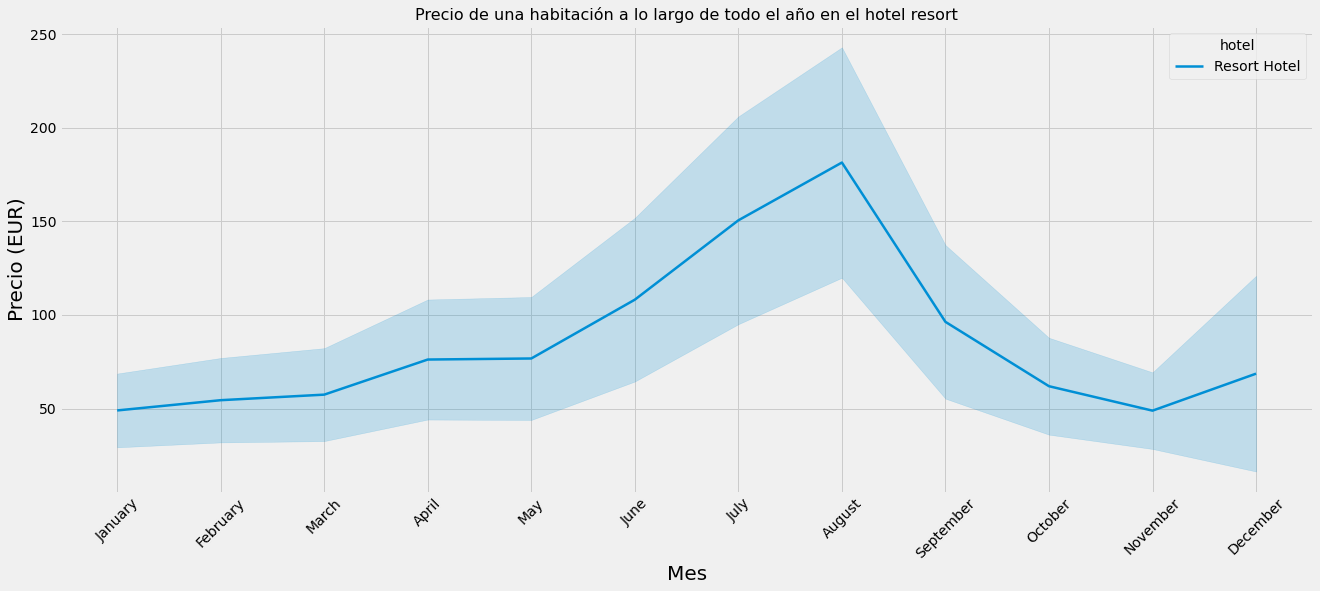

In [28]:
import seaborn as sns
resort_pm = resort[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
resort_pm["arrival_date_month"] = pd.Categorical(resort_pm["arrival_date_month"], categories=months, ordered=True)

# incluida desviacion estandar
plt.figure(figsize=(20, 8))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=resort_pm,
            ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Precio de una habitación a lo largo de todo el año en el hotel resort", fontsize=16)
plt.xlabel("Mes", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Precio (EUR)", fontsize=20)
plt.show()

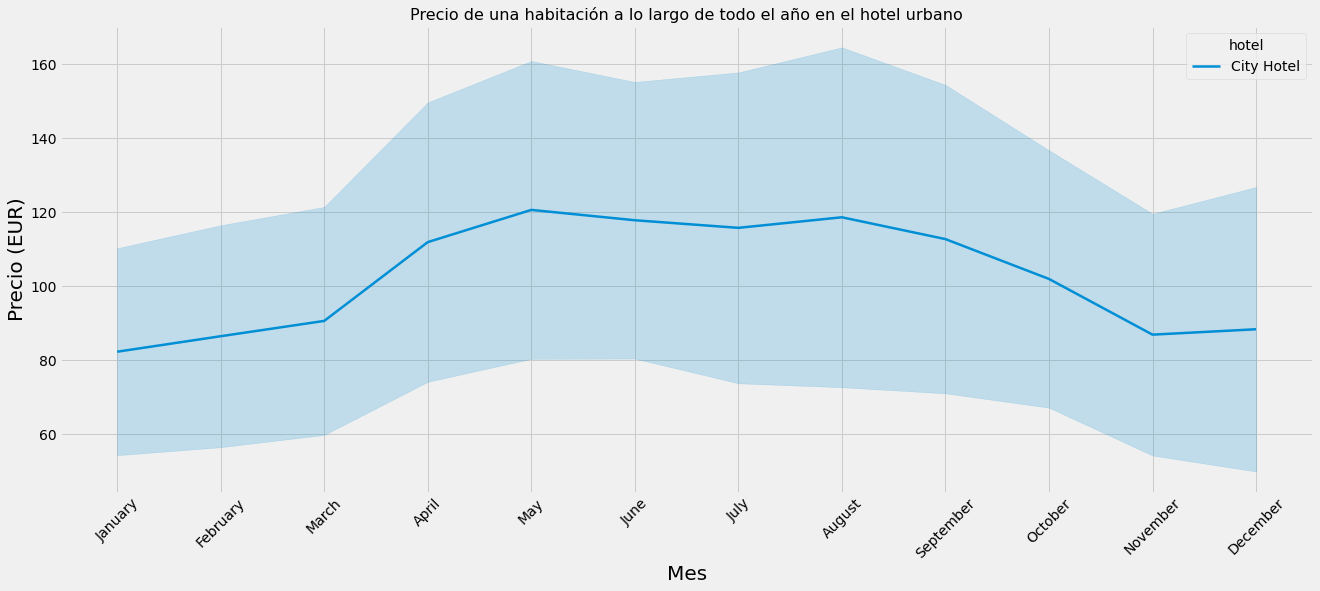

In [29]:
city_pm = city[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

city_pm["arrival_date_month"] = pd.Categorical(city_pm["arrival_date_month"], categories=months, ordered=True)

# incluida desviacion estandar
plt.figure(figsize=(20, 8))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=city_pm,
            ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Precio de una habitación a lo largo de todo el año en el hotel urbano", fontsize=16)
plt.xlabel("Mes", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Precio (EUR)", fontsize=20)
plt.show()

Se ven bien las gráficas, pero el resultado se puede apreciar mejor si se superponen 

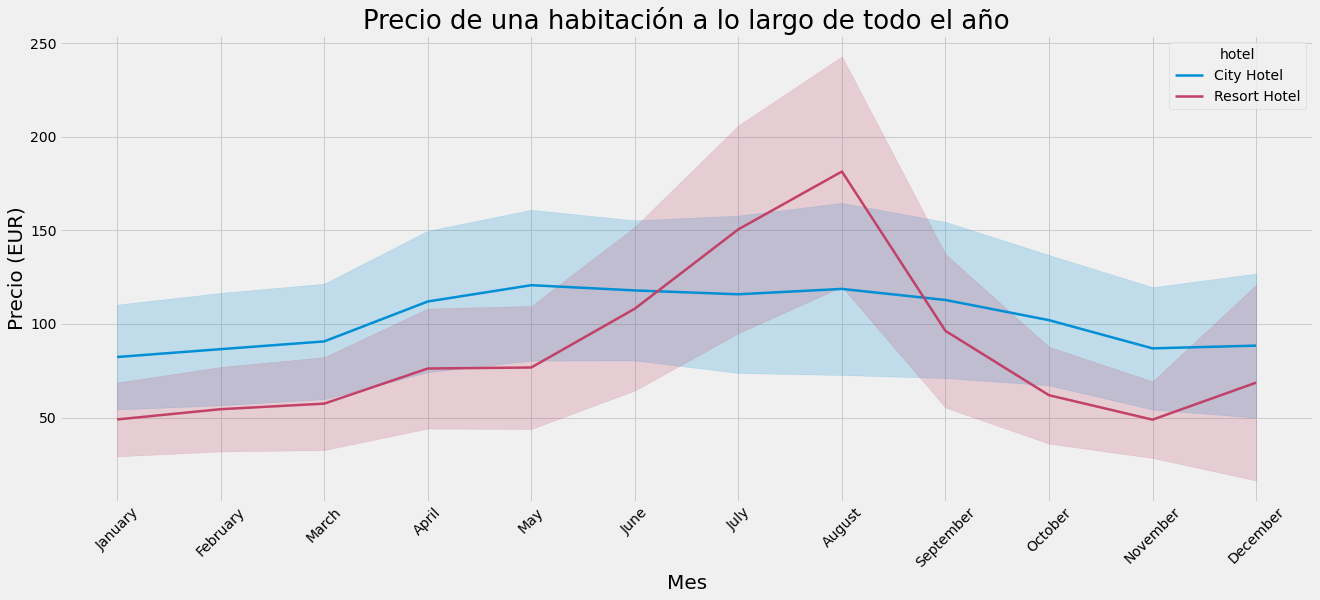

In [30]:
plt.figure(figsize=(20, 8))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=city_pm,
            ci="sd", size="hotel", sizes=(2.5, 2.5))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=resort_pm,
            palette="flare", ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Precio de una habitación a lo largo de todo el año", fontsize=26)
plt.xlabel("Mes", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Precio (EUR)", fontsize=20)
plt.show()

Salvo en la temporada de verano (alrededor de junio,julio,agosto y septiembre) el hotel urbano es más costoso que el hotel resort. Es normal que el precio de el resort suba en verano porque es temporada vacacional en toda europa.

# 4. **¿Cuáles son los meses más ocupados?**

Para esta pregunta se calculará el número promedio de personas hospedadas mensualmente.

In [31]:
#agrupamos los datos por año y mes
hotels_data = df_new.groupby(["arrival_date_month","arrival_date_year"])["hotel"].count()
hotels_data

arrival_date_month  arrival_date_year
April               2016.0               5401
                    2017.0               5637
August              2015.0               3867
                    2016.0               5046
                    2017.0               4923
December            2015.0               2893
                    2016.0               3817
February            2016.0               3851
                    2017.0               4146
January             2016.0               2215
                    2017.0               3651
July                2015.0               2760
                    2016.0               4540
                    2017.0               5310
June                2016.0               5278
                    2017.0               5639
March               2016.0               4783
                    2017.0               4929
May                 2016.0               5463
                    2017.0               6305
November            2015.0               2

Vemos que todos los meses tienen registros de dos años (2016 y 2017) salvo agosto y julio que tienen tres años de registro (2015, 2016 y 2017).

Para comparar todos los meses de manera equitativa, vamos a normalizar los datos para cada hotel.

In [32]:
#primero, agrupamos los datos de los hoteles por mes
resort_m = resort.groupby(["arrival_date_month"])["hotel"].count()
resort_m = pd.DataFrame({"month": list(resort_m.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_m.values)})

city_m = city.groupby(["arrival_date_month"])["hotel"].count()
city_m = pd.DataFrame({"month": list(city_m.index),
                    "hotel": "City hotel", 
                    "guests": list(city_m.values[:])})
#segundo, concatenamos los datos de ambos hoteles
all_data = pd.concat([resort_m,city_m], ignore_index=True)
all_data["month"] = pd.Categorical(all_data["month"], categories=months, ordered=True)

#tercero, normalizamos los datos para evitar sesgo en nuestro análisis
all_data.loc[(all_data["month"] == "July") | (all_data["month"] == "August"),"guests"] /= 3
all_data.loc[~((all_data["month"] == "July") | (all_data["month"] == "August")),"guests"] /= 2


In [33]:
#Ahora sí, aquí está la lista de los meses con mayor ocupación hotelera, en promedio
all_data.sort_values(["guests"],ascending=False)

,month,hotel,guests
20,May,City hotel,2284.000000
18,June,City hotel,2179.000000
22,October,City hotel,2163.000000
23,September,City hotel,2141.500000
19,March,City hotel,2024.500000
12,April,City hotel,2005.000000
13,August,City hotel,1789.000000
17,July,City hotel,1590.000000
15,February,City hotel,1525.500000
21,November,City hotel,1337.000000


¡Perfecto! Pero podemos visualizarlo un poco mejor. Así que aquí va una serie de tiempo. El número de huespedes hospedados en función de los meses 

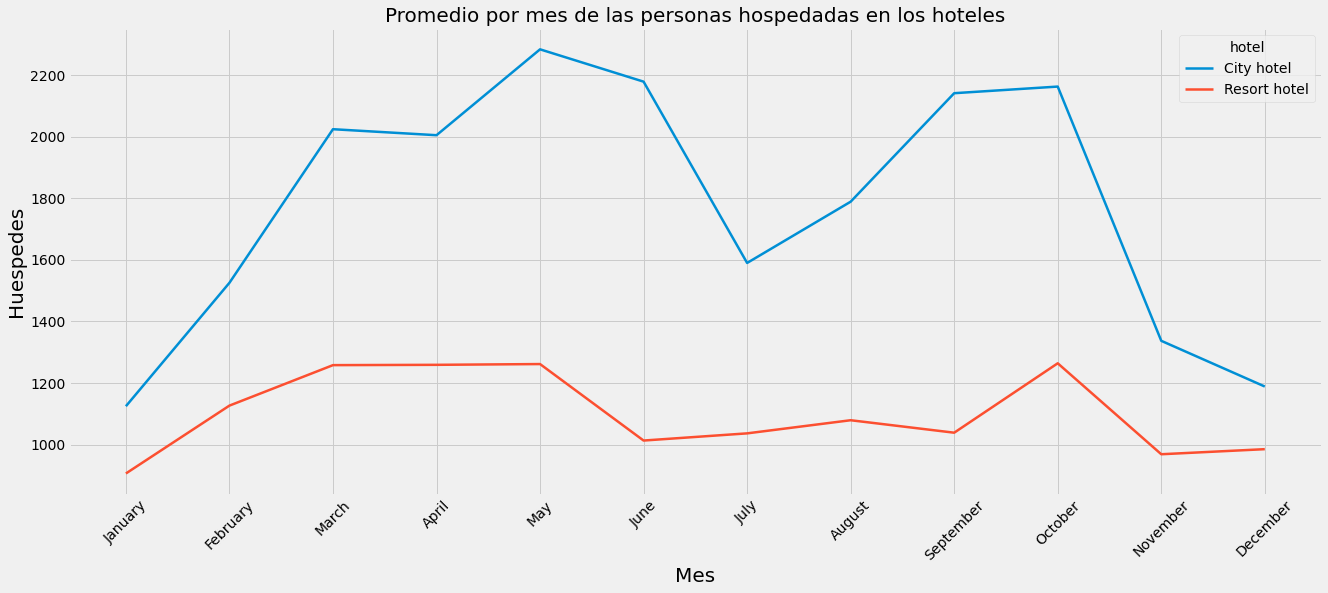

In [34]:
plt.figure(figsize=(20, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=all_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Promedio por mes de las personas hospedadas en los hoteles", fontsize=20)
plt.xlabel("Mes", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Huespedes", fontsize=20)
plt.show()

Los meses anteriores y posteriores al verano son los meses con mayor ocupación.

# 5. **¿Cuánto tiempo se queda la gente en los hoteles (noches)?**



In [35]:
#Hay que sumar el numero de noche entre semana y las de los fines de semana
resort["total_nights"] = resort["stays_in_weekend_nights"] + resort["stays_in_week_nights"]
#Calcular el porcentaje de las personas que están hospedadas
nights_r = list(resort["total_nights"].value_counts().index)
num_br = list(resort["total_nights"].value_counts())
pop_resort = resort["total_nights"].value_counts() / sum(num_br) * 100

nights_resort = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": nights_r,
                           "percentage_of_people": pop_resort})
#Hacer lo mismo para el hotel urbano
city["total_nights"] = city["stays_in_weekend_nights"] + city["stays_in_week_nights"]

nights_c = list(city["total_nights"].value_counts().index)
num_bc = list(city["total_nights"].value_counts())
pop_city = city["total_nights"].value_counts() / sum(num_bc) * 100 

nights_city = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": nights_c,
                           "percentage_of_people": pop_city})
#concatenar los data frames
nights_data = pd.concat([nights_resort, nights_city], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
#Ahora sí, aquí está la lista de los meses con mayor ocupación hotelera, en promedio
nights_data.sort_values(["percentage_of_people"],ascending=False).head(10)

,hotel,num_nights,percentage_of_people
33,City hotel,3.0,25.797491
34,City hotel,2.0,23.833601
0,Resort hotel,1.0,22.339157
35,City hotel,1.0,19.866759
36,City hotel,4.0,16.694154
1,Resort hotel,7.0,15.526556
2,Resort hotel,2.0,15.372202
3,Resort hotel,3.0,13.309479
4,Resort hotel,4.0,11.587034
37,City hotel,5.0,6.965843


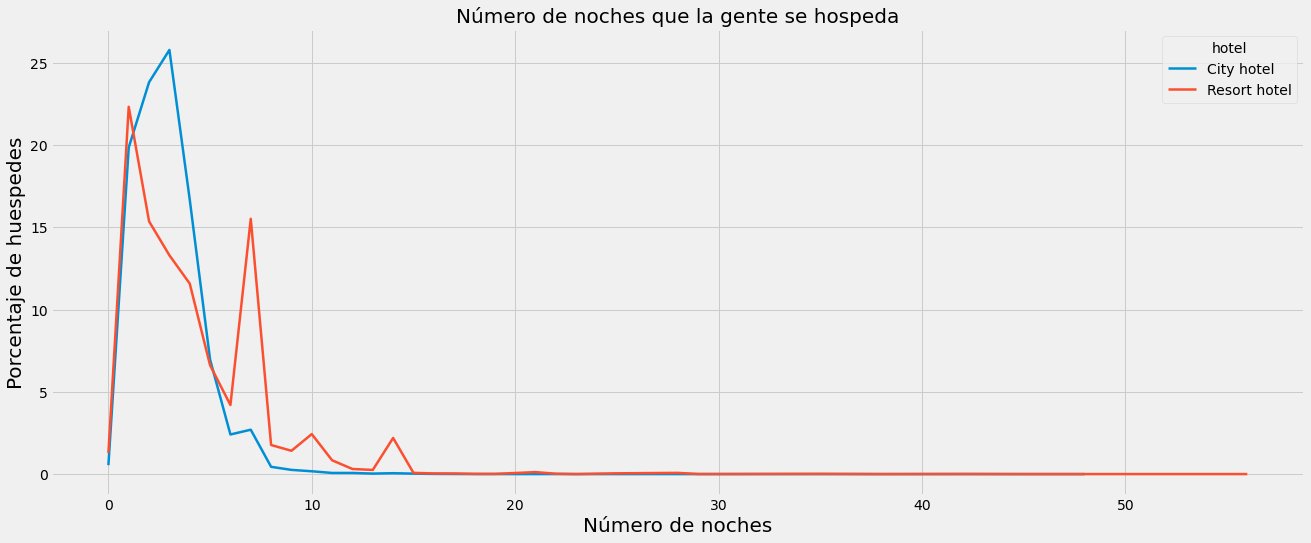

In [37]:
#visualizar graficamente
plt.figure(figsize=(20, 8))
sns.lineplot(x = "num_nights", y="percentage_of_people", hue="hotel", data=nights_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Número de noches que la gente se hospeda", fontsize=20)
plt.xlabel("Número de noches", fontsize=20)
plt.ylabel("Porcentaje de huespedes", fontsize=20)
plt.show()

La mayoria de las personas de las personas (cerca del 26%)se hospeda por 3 noches en el hotel urbano. Por otra parte, la mayoria de las personas (23%) solamente se hospeda una noche en el hotel resort 

# 6. **Reservas por segmento de mercado**



In [38]:
segment = df_new.market_segment.value_counts(normalize=True)
segment

Online TA        0.474479
Offline TA/TO    0.203199
Groups           0.166644
Direct           0.104636
Corporate        0.042948
Complementary    0.006115
Aviation         0.001979
Name: market_segment, dtype: float64

Cerca del 47.4 % de las reservas fueron hechas a través de agencias de viajes (Travel Agents) vía online. Mientras que el 20% fueron hechas por agencias de viajes de manera offline. Por otro lado, solo un 10% de las reservas se hizo directamente en el hotel.

Lo siento, las otras variables no las puedo interpretar correctamente 
:(

# 7. **¿Cuántas reservas se cancelaron?**

In [39]:
# cancelaciones totales
resort_tmp = df_new.loc[df_new["hotel"] == "Resort Hotel"]
city_tmp = df_new.loc[df_new["hotel"] == "City Hotel"]
total_cancel = df_new["is_canceled"].sum()
resort_cancel = resort_tmp["is_canceled"].sum()
city_cancel = city_tmp["is_canceled"].sum()

# porcentaje:
p_cancel = total_cancel / df_new.shape[0] * 100
p_resort_cancel = resort_cancel / resort_tmp.shape[0] * 100
p_city_cancel = city_cancel / city_tmp.shape[0] * 100

print("""Total de reservas cancelladas: {} ({:.3f} %)
Reservas canceladas en el hotel resort: {} ({:.3f} %)
Reservas canceladas en el hotal urbano: {} ({:.3f} %)"""
      .format(total_cancel, p_cancel, resort_cancel, p_resort_cancel, city_cancel, p_city_cancel))

Total de reservas cancelladas: 44138.0 (37.176 %)
Reservas canceladas en el hotel resort: 11077.0 (27.984 %)
Reservas canceladas en el hotal urbano: 33061.0 (41.774 %)


Text(0, 0.5, 'Tiempo de espera')

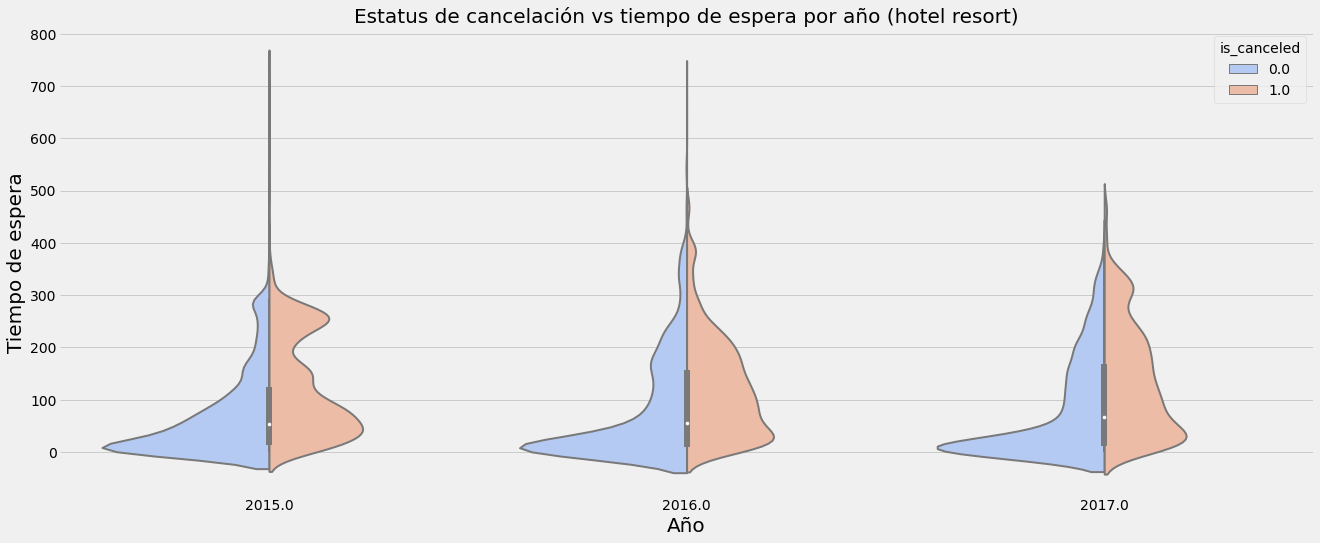

In [40]:
# Vamos a ver la distribución de las reservas que se cancelaron cada año para el resort en función del tiempo de espera
plt.figure(figsize=(20,8))
sns.violinplot(x='arrival_date_year', y ='lead_time', hue="is_canceled", data=resort_tmp, palette="coolwarm", bw=.2,
               cut=2, linewidth=2, iner= 'box', split = True)
sns.despine(left=True)
plt.title('Estatus de cancelación vs tiempo de espera por año (hotel resort)', fontsize=20)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Tiempo de espera', fontsize=20)

Los tres años muestran que la distribución del tiempo de espera respecto a las reservas canceladas varía cada año, sin embargo muestran medianas rangos intercuartiles similares.

Por otro lado, la distribución del tiempo de espera respecto a las reservas que no fueron canceladas se ve mosfologicamente similar para los años 2016 y 2017, los cuales tienen un registro completo de los 12 meses.

Text(0, 0.5, 'Tiempo de espera')

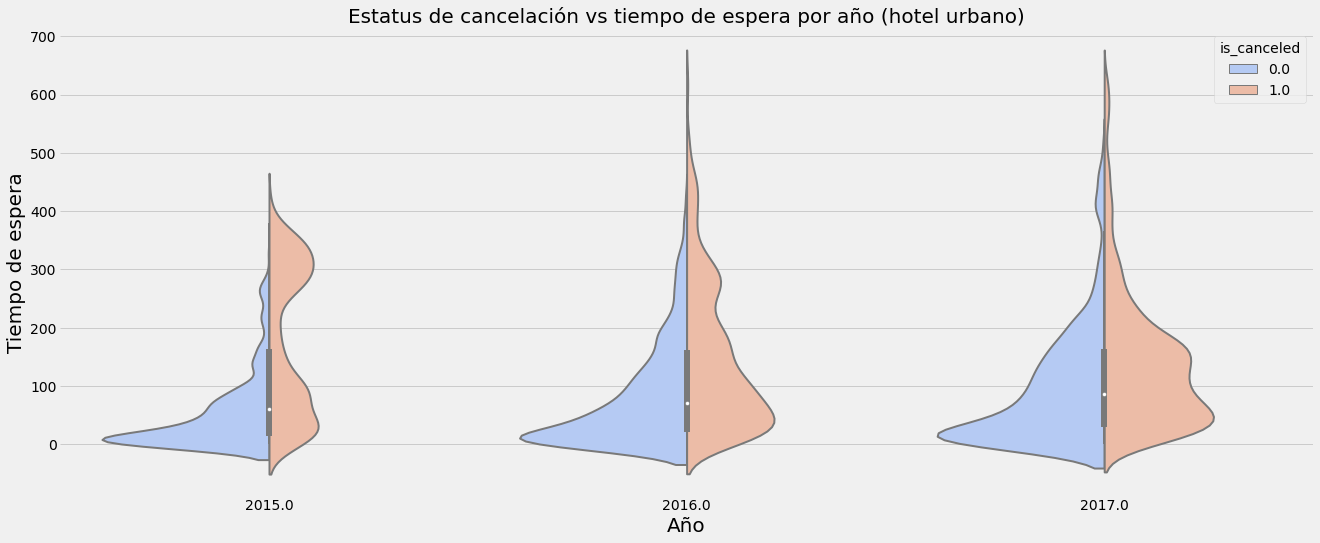

In [41]:
# Vamos a ver la distribución de las reservas que se cancelaron cada año para el hotel urbano en función del tiempo de espera
plt.figure(figsize=(20,8))
sns.violinplot(x='arrival_date_year', y ='lead_time', hue="is_canceled", data=city_tmp, palette="coolwarm", bw=.2,
               cut=2, linewidth=2, iner= 'box', split = True)
sns.despine(left=True)
plt.title('Estatus de cancelación vs tiempo de espera por año (hotel urbano)', fontsize=20)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Tiempo de espera', fontsize=20)

Las concluciones de imagen anterior es similar a la obtenida a la que se obtuvo para el hotel resort.

Así que pasaremos a la siguiente pregunta

# 8. **¿Qué mes tiene el mayor número de cancelaciones?**

In [42]:
resort_bpm = resort_tmp.groupby("arrival_date_month")["hotel"].count()
resort_cpm = resort_tmp.groupby("arrival_date_month")["is_canceled"].sum()

city_bpm = city_tmp.groupby("arrival_date_month")["hotel"].count()
city_cpm = city_tmp.groupby("arrival_date_month")["is_canceled"].sum()

resort_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(resort_bpm.index),
                                "Bookings": list(resort_bpm.values),
                                "Cancelations": list(resort_cpm.values)})
city_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(city_bpm.index),
                                "Bookings": list(city_bpm.values),
                                "Cancelations": list(city_cpm.values)})

total_cancel_data = pd.concat([resort_cancel_data, city_cancel_data], ignore_index=True)
total_cancel_data["Month"] = pd.Categorical(total_cancel_data["Month"], categories=months, ordered=True)
#Aquí se muestra la lista de los meses con mayor número de cancelaciones
total_cancel_data.sort_values(["Cancelations"],ascending=False).head(10)


,Hotel,Month,Bookings,Cancelations
20,City Hotel,May,8221,3653.0
13,City Hotel,August,8963,3596.0
18,City Hotel,June,7885,3527.0
12,City Hotel,April,7469,3459.0
17,City Hotel,July,8071,3301.0
22,City Hotel,October,7580,3254.0
23,City Hotel,September,7392,3109.0
19,City Hotel,March,6434,2385.0
15,City Hotel,February,4950,1899.0
14,City Hotel,December,4114,1737.0


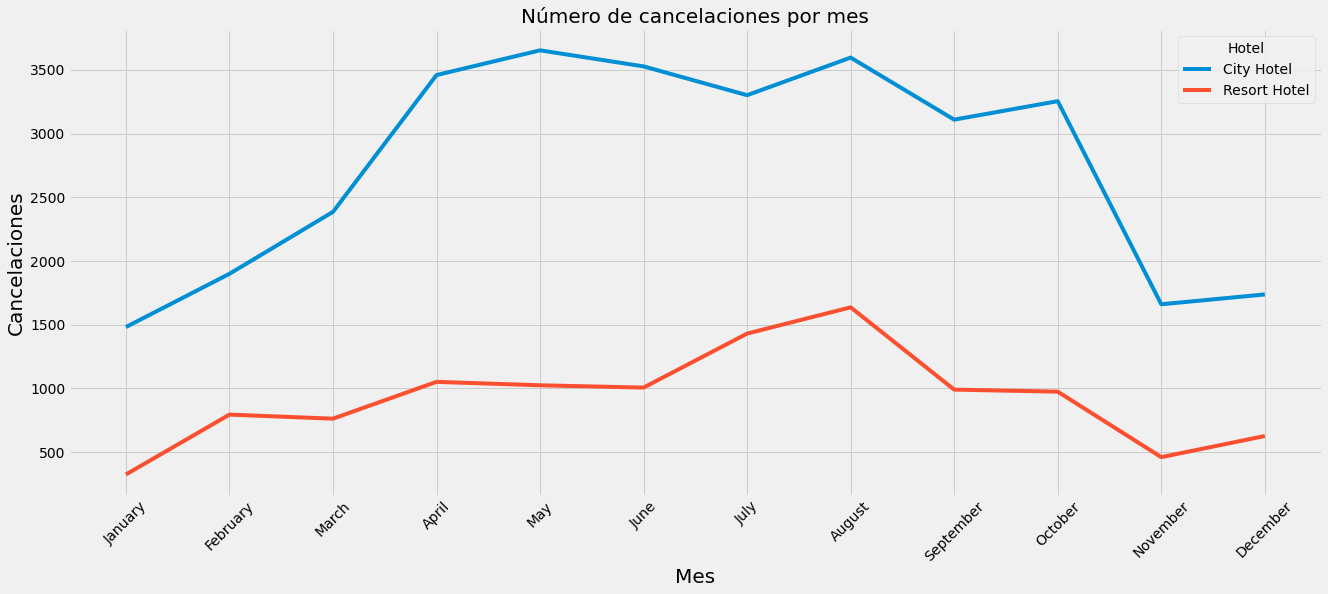

In [43]:
plt.figure(figsize=(20, 8))
sns.lineplot(x = "Month", y = "Cancelations" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=total_cancel_data)
plt.title("Número de cancelaciones por mes", fontsize=20)
plt.xlabel("Mes", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Cancelaciones", fontsize=20)
plt.show()

Para el hotel urbano, el mes con mayor número de cancelaciones fue mayo. Mientras que para el resort fue el mes de agosto.

# 9. **Hacer tabla de correlación para las variables**

In [44]:
#primero, convertir todas las variables categoricas a enteros usando 'LabelEncoder'
from sklearn.preprocessing import LabelEncoder

df_encoder = df_new.drop(['is_canceled'], axis=1).copy()
le = LabelEncoder()

num = list(df_new.select_dtypes(include=['float64']).drop(['is_canceled'], axis=1).columns)

cat = list(df_new.select_dtypes(include=['object']).columns)

for col in cat:
    df_encoder[col] = le.fit_transform(df_encoder[col])

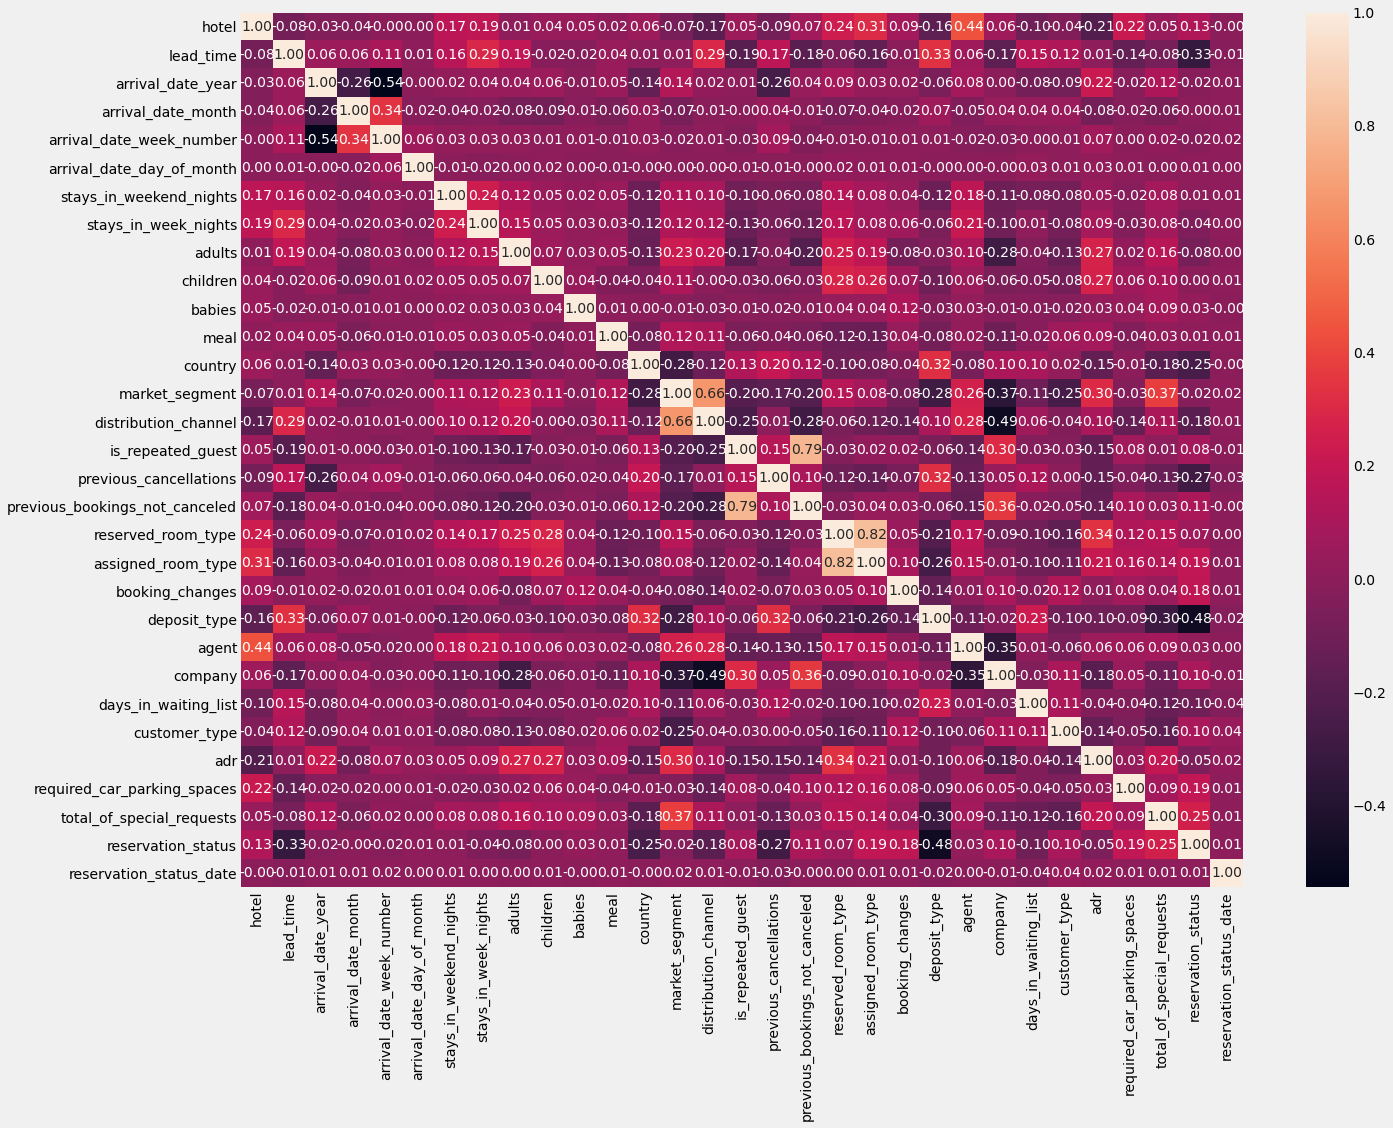

In [45]:
# Spearman method
plt.figure(figsize=(20, 15))
sns.heatmap(df_encoder.corr(method='spearman'), annot=True, fmt='.2f');

# 10. **Encontrar las mejores variables para predecir cancelaciones**

Antes de proceder a modelar los datos, se necesita eliminar tantas variables como sea posible. El proposito de esto es obtener el modelo lo mas simple posible y así evitar el sobre entrenamiento.

En esta matriz de correlación, se puede observar que hay una fuerte correlación negativa entre las variables **reservation_status** y **is_canceled**. Hay otras fuertes correlación entre **arrival_date_year** y **arrival_date_week_number**; **assigned_room_type** y **reserved_room_type**; **is_repeated_guest** y **previous_bookings_not_canceled**; **distribution_channel** y **market_segment**. Debido a estas correlaciones, se puede eliminar las columnas
**reservation_status**, **assigned_room_type**, **is_repeated_guest**, **arrival_date_year** y **distribution_channel** features.



In [46]:
#eliminar las variables
columns = [
    'reservation_status',
    'arrival_date_year',
    'assigned_room_type',
    'is_repeated_guest',
    'distribution_channel'

]

df_encoder = df_encoder.drop(columns, axis=1)

In [47]:
#dividir los features del target
X_le = df_encoder
y = df_new['is_canceled']

Ahora vamos a determinar mejores variables para predecir cancelaciones. Para hacer esto vamos a graficar la importancia de la permutación de los feutures usando el clasificador Extreme Gradient Boosting. De acurdo con la teoría, el cálculo de la importancia se calculan explícitamente para cada feature en el conjunto de datos, lo que permite éstos se clasifiquen y comparen entre sí.

In [48]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

# algoritmo de clasificación XGB
params = {
    'criterion': 'giny', 
    'learning_rate': 0.01, 
    'max_depth': 50,
    'n_estimators': 100, 
    'objective': 'binary:logistic',
     'n_jobs':-1
}
model = XGBClassifier(parameters=params)
# ajustar el modelo
model.fit(X_le, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              parameters={'criterion': 'giny', 'learning_rate': 0.01,
                          'max_depth': 50, 'n_estimators': 100, 'n_jobs': -1,
                          'objective': 'binary:logistic'},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [49]:
# vamos a medir mide el aumento en el error de predicción del modelo después de que permutamos los valores 
# de los features
result = permutation_importance(model, X_le, y, scoring='accuracy', n_repeats = 10)
sorted_idx = result.importances_mean.argsort()

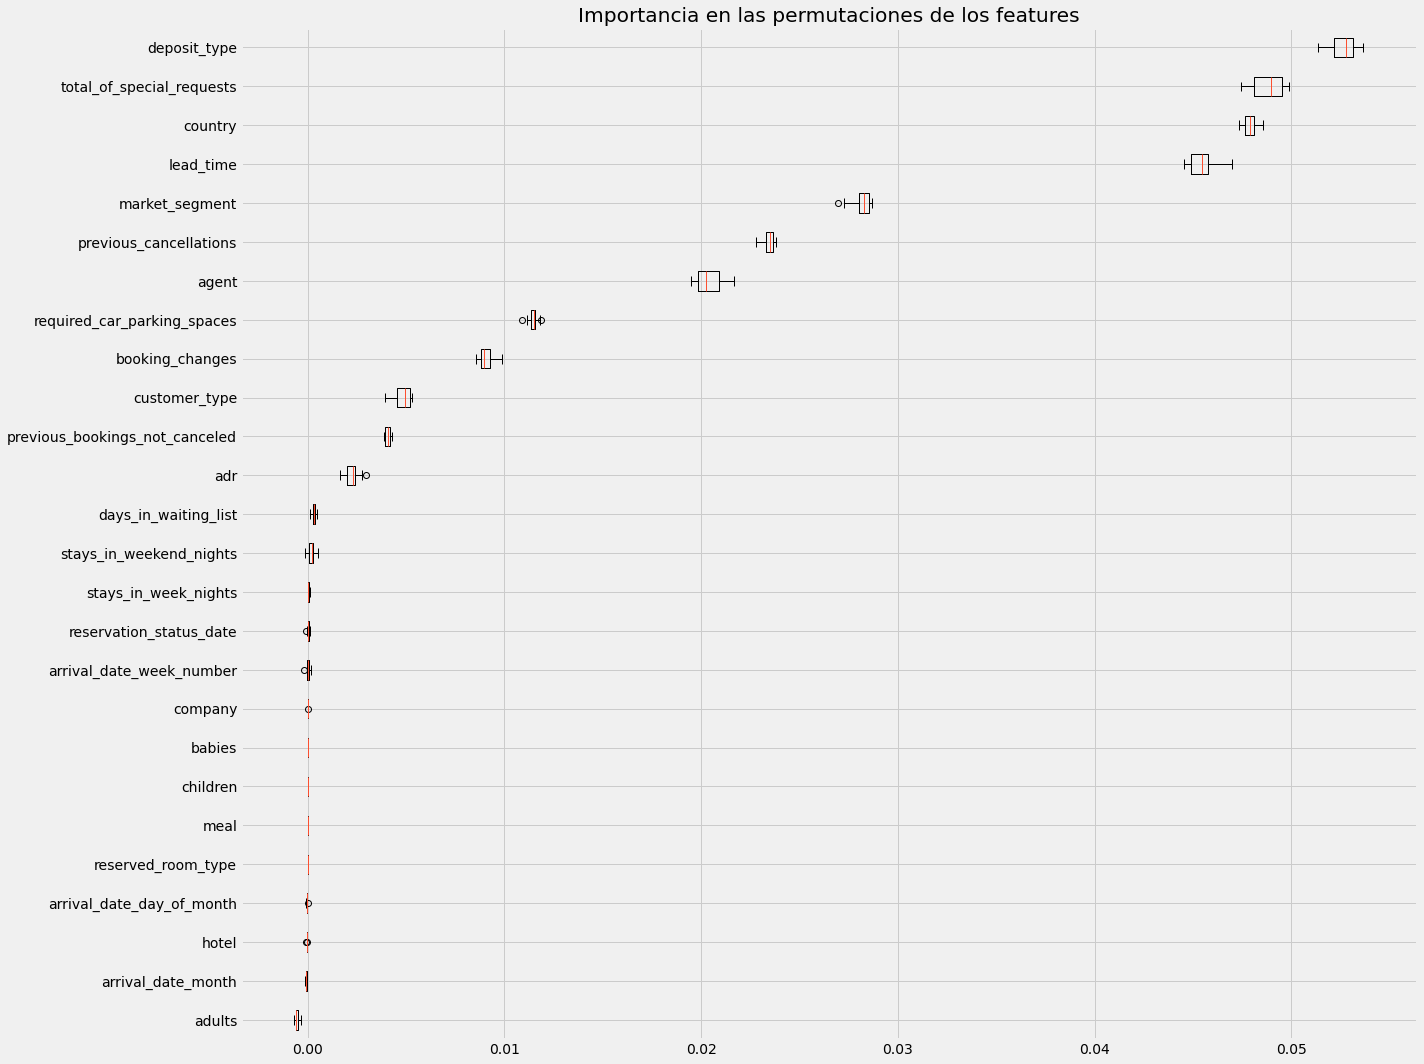

In [50]:
# gráfico de la importancia en las permutaciones
fig, ax = plt.subplots(figsize=(20,15))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_le.columns[sorted_idx])
ax.set_title("Importancia en las permutaciones de los features")
fig.tight_layout()
plt.show()

Del gráfico de arriba se puede concluir que las 5 mejores variables para predecir las cancelaciones son: 
1. El tipo de deposito.
2. El total depeticiones especiales.
3. El País de origen de los huespedes.
4. El tiempo de espera.
5. La segmentación del mercado.

# 11. **Predecir a través de 3 diferentes modelos.**
# 12. **Para cada modelo elegido, utilice un K-Fold de 4 y evalúe el cross_val_score**

Antes de implementar los modelos, vamos a dividir el conjunto de datos en dos subconjuntos, uno para entrenamiento y otro para testeo (70% y 30%, respectivamente). Después se usará el método K-Fold para hacer un 'cross-validation'.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_le, y, test_size=.3, random_state=42)

In [52]:
# Usar standard scaler
from sklearn.preprocessing import StandardScaler

standardScalerX = StandardScaler()
X_train = standardScalerX.fit_transform(X_train)
X_test = standardScalerX.fit_transform(X_test)

In [53]:
# K-Fold Cross-Validation 
from sklearn.model_selection import StratifiedKFold

kfold=StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

for train_index, test_index in kfold.split(X_le,y):
    X_train, X_test = X_le.iloc[train_index], X_le.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [54]:
#Primer modelo: Decision Tree
from sklearn.tree import DecisionTreeClassifier

model_1 = DecisionTreeClassifier(criterion= 'gini', min_samples_split=8,
                                  min_samples_leaf = 4, max_features = 'auto')
#ajustar
model_1.fit(X_train, y_train)

# prediccion
predict_1 = model_1.predict(X_test)

In [55]:
#Segundo modelo: Random Forest
from sklearn.ensemble import RandomForestClassifier

model_2 = RandomForestClassifier(min_samples_leaf = 6, min_samples_split=6,
                                  n_estimators = 100)
# ajustar
model_2.fit(X_train, y_train)
# prediccion
predict_2 = model_2.predict(X_test)

In [56]:
#Tercer modelo: Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

model_3 = ExtraTreesClassifier(min_samples_leaf = 7, min_samples_split=2,
                                  n_estimators = 100)
# ajustar
model_3.fit(X_train, y_train)

# prediccion
predict_3 = model_3.predict(X_test)

In [57]:
#cuarto modelo: Extreme Gradient Boosting 
model_4 = XGBClassifier(criterion = 'giny', learning_rate = 0.01, max_depth = 5, n_estimators = 100,
                          objective ='binary:logistic', subsample = 1.0)
# ajustar
model_4.fit(X_train, y_train)
# prediccion
predict_4 = model_4.predict(X_test)

In [58]:
#quinto modelo: Logistic Regression

modelo_5 = LogisticRegression().fit(X_train, y_train)
predict_5 = modelo_5.predict(X_test)

# 13. **¿Cuál es el modelo con mayor performance?**

In [59]:
#Comparación de los 5 modelos.
print("DecisionTreeClassifier", classification_report(y_test, predict_1))
print("RandomForestClassifier",classification_report(y_test, predict_2))
print("ExtraTreesClassifier", classification_report(y_test, predict_3))
print("Extreme Gradient Boosting ", classification_report(y_test, predict_4))
print("Logistic Regression", classification_report(y_test, predict_5))

DecisionTreeClassifier               precision    recall  f1-score   support

         0.0       0.87      0.90      0.89     18647
         1.0       0.82      0.77      0.80     11034

    accuracy                           0.85     29681
   macro avg       0.85      0.84      0.84     29681
weighted avg       0.85      0.85      0.85     29681

RandomForestClassifier               precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     18647
         1.0       0.89      0.81      0.85     11034

    accuracy                           0.89     29681
   macro avg       0.89      0.88      0.88     29681
weighted avg       0.89      0.89      0.89     29681

ExtraTreesClassifier               precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     18647
         1.0       0.90      0.73      0.81     11034

    accuracy                           0.87     29681
   macro avg       0.88      0.84      0.85     29681
weighte

Text(64.9, 0.5, 'Reales')

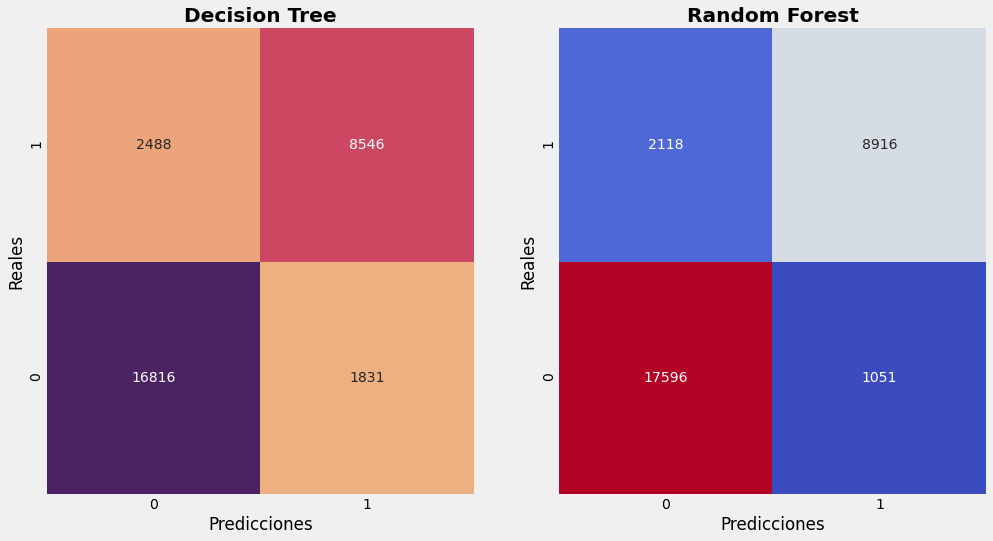

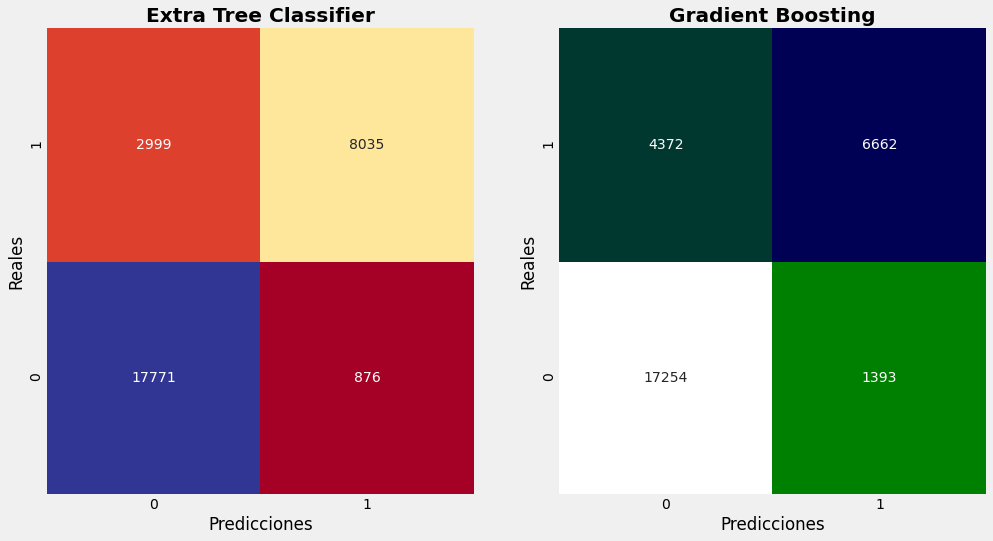

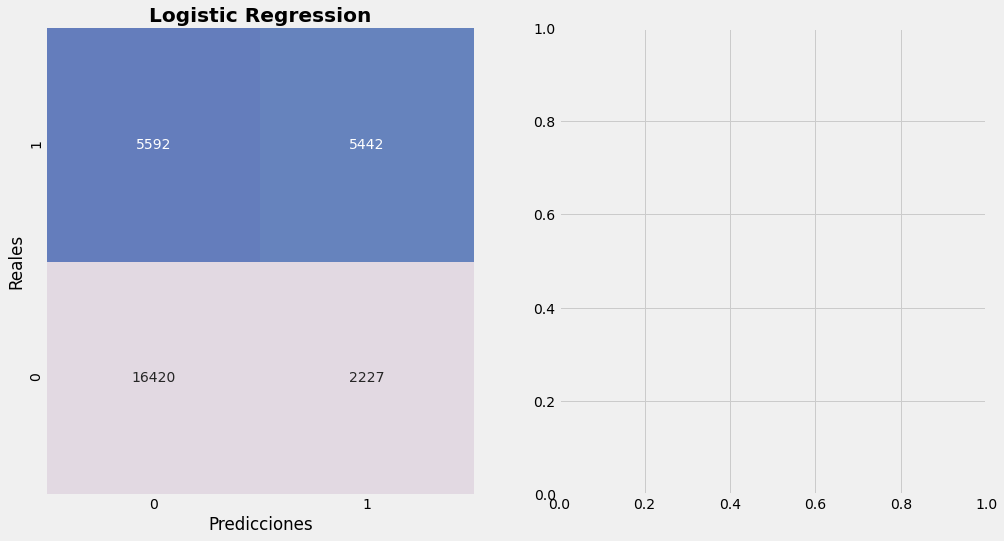

In [60]:
# Matriz de confusion y Area bajo la curva
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

model1_matrix = confusion_matrix(y_test, predict_1)
model2_matrix = confusion_matrix(y_test, predict_2)
model3_matrix = confusion_matrix(y_test, predict_3)
model4_matrix = confusion_matrix(y_test, predict_4) 
model5_matrix = confusion_matrix(y_test, predict_5)


fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(model1_matrix,annot=True, fmt="d", cbar=False, cmap="flare",  ax = ax[0]).set_ylim([0,2])
ax[0].set_title("Decision Tree", weight='bold')
ax[0].set_xlabel('Predicciones')
ax[0].set_ylabel('Reales')
sns.heatmap(model2_matrix,annot=True, fmt="d" ,cbar=False, cmap="coolwarm", ax = ax[1]).set_ylim([0,2])
ax[1].set_title("Random Forest", weight='bold')
ax[1].set_xlabel('Predicciones')
ax[1].set_ylabel('Reales')

fig, axe = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(model3_matrix,annot=True, fmt="d", cbar=False, cmap="RdYlBu", ax = axe[0]).set_ylim([0,2])
axe[0].set_title("Extra Tree Classifier", weight='bold')
axe[0].set_xlabel('Predicciones')
axe[0].set_ylabel('Reales')
sns.heatmap(model4_matrix,annot=True, fmt="d", cbar=False, cmap="ocean", ax = axe[1]).set_ylim([0,2])
axe[1].set_title("Gradient Boosting", weight='bold')
axe[1].set_xlabel('Predicciones')
axe[1].set_ylabel('Reales')

fig, axe = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(model5_matrix,annot=True, fmt="d", cbar=False, cmap="twilight", ax = axe[0]).set_ylim([0,2])
axe[0].set_title("Logistic Regression", weight='bold')
axe[0].set_xlabel('Predicciones')
axe[0].set_ylabel('Reales')

Ahora podemos con precisión cual es el modelo que mejor responde a la pregunta ¿qué porcentaje de los clientes que tienen una reserva cancelaran?

Los modelos **Random Forest** y **Extra Trees** son los que tienen mejor precisión, a saber: del 89 % y del 90 % respectivamente.

Por otro lada, la métrica Recall que nos informar sobre la *cantidad* que el modelo es capaz de identificar. Es decir, ayuda a responder a preguntas del tipo ¿qué porcentaje de los clientes que están por cancelar somos capaces de identificar?

En este caso, los modelos **Random Forest** y **Extra Trees** tienen un recall del 81 % y del 0.73 %, respectivamente.

Por tanto, podemos concluir que el mejor modelo es el **Random Forest**.

